In [1]:
import os
import mdtraj as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


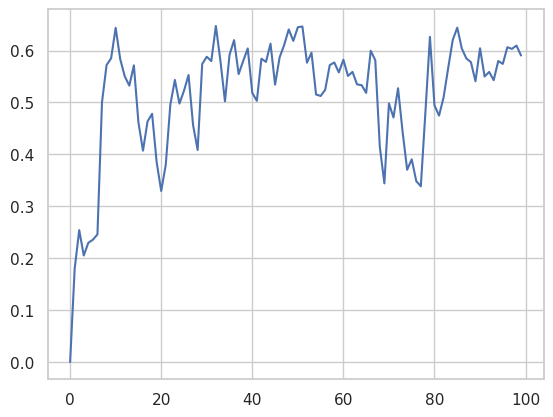

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


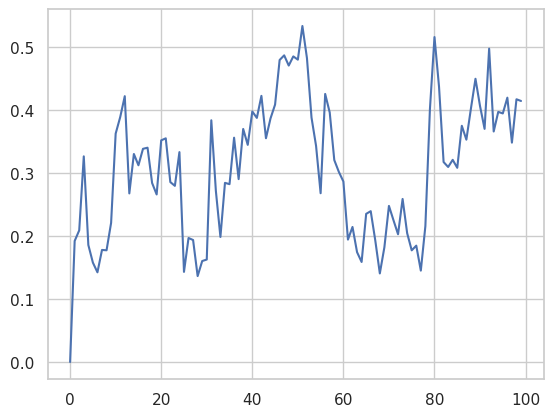

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


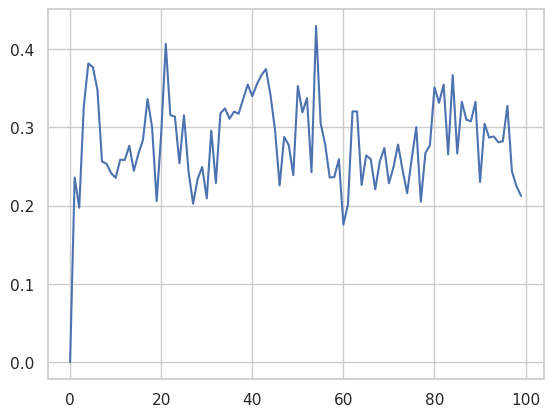

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


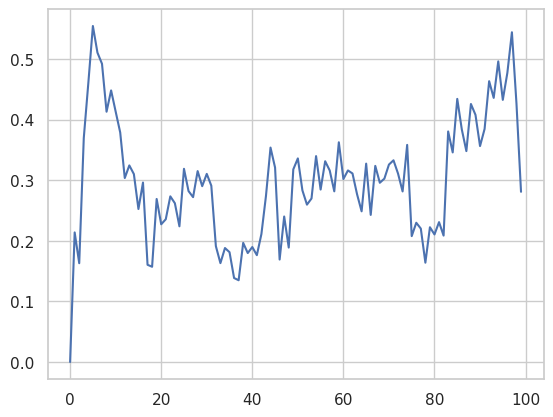

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


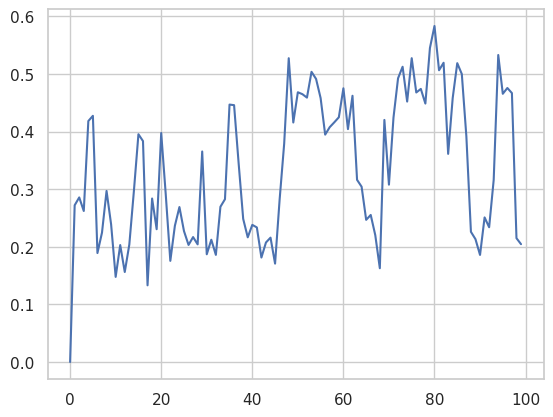

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


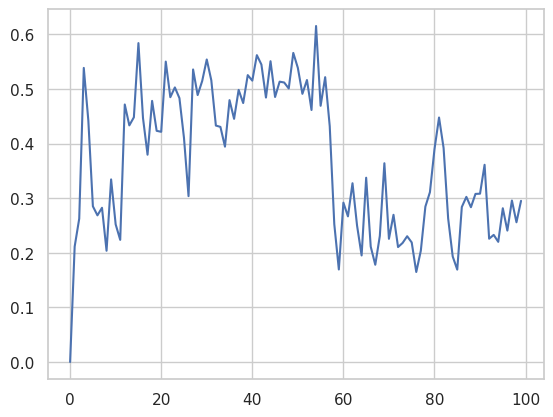

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


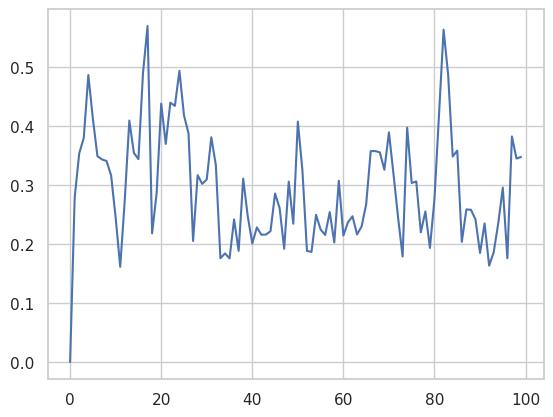

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


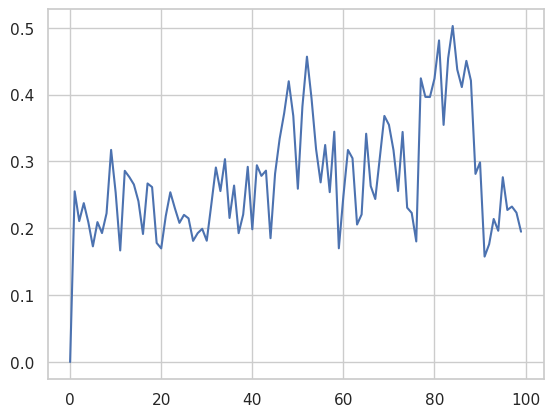

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


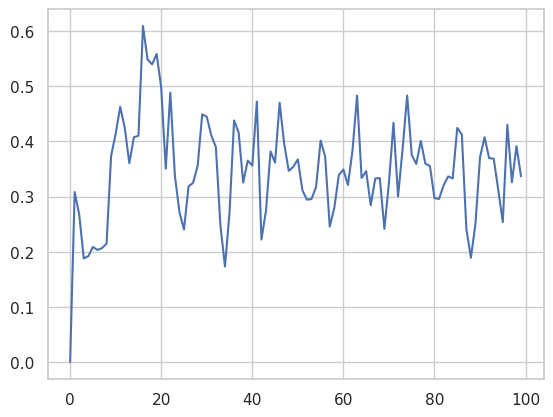

dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)


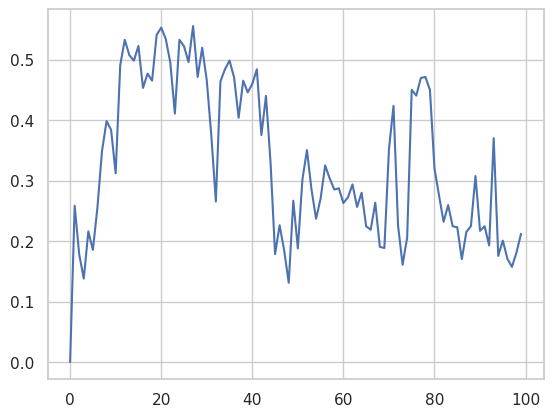

In [51]:
def analysis(traj_files, top_file, slice_step=1):
    for i, traj_file in enumerate(traj_files):
        traj = md.load(traj_file, top=top_file)[::slice_step]
        traj.image_molecules(inplace=True)
        protein_atoms = traj.topology.select('protein and name CA')
        traj.superpose(traj, frame=0, atom_indices=protein_atoms)
        ligand_atoms = traj.topology.select('resname UNK')
        result = traj.xyz[:, ligand_atoms, :] - traj.xyz[0, ligand_atoms, :]
        ligand_rmsd = np.sqrt((result ** 2).sum(axis=-1).mean(axis=-1))
        plt.plot(ligand_rmsd)
        plt.show()
        plt.close()
        traj.save(f'rep{i}_processed.xtc')

for i in range(10):
    analysis(['rep_' + str(i) + '/trj.dcd'], 'minimized_system.pdb')

In [4]:
!pwd

/mnt/c/Users/cha13/Desktop/blog_in_progress/binary_complex/openbpmd


In [7]:
from simtk.openmm import *
from simtk.openmm.app import *
from simtk.unit import *
try:
    from simtk.openmm.app.metadynamics import *
except:
    from openmm.app.metadynamics import *

# The rest
import argparse
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import rms, contacts
import mdtraj as md
import pandas as pd
import parmed as pmd
import glob
import os

In [34]:
def get_PMF(out_dir, idx, lig_resname, eq_pdb, parm, parm_file,
            coords_file, set_hill_height):
    """An OpenBPMD production simulation function. Ligand RMSD is biased with
    metadynamics. The integrator uses a 4 fs time step and
    runs for 10 ns, writing a frame every 100 ps.

    Writes a 'trj.dcd', 'COLVAR.npy', 'bias_*.npy' and 'sim_log.csv' files
    during the metadynamics simulation in the '{out_dir}/rep_{idx}' directory.
    After the simulation is done, it analyses the trajectories and writes a
    'bpm_results.csv' file with time-resolved PoseScore and ContactScore.

    Parameters
    ----------
    out_dir : str
        Directory where your equilibration PDBs and 'rep_*' dirs are at.
    idx : int
        Current replica index.
    lig_resname : str
        Residue name of the ligand.
    eq_pdb : str
        Name of the PDB for equilibrated system.
    parm : Parmed or OpenMM parameter file object
        Used to create the OpenMM System object.
    parm_file : str
        The name of the parameter or topology file of the system.
    coords_file : str
        The name of the coordinate file of the system.
    set_hill_height : float
        Metadynamic hill height, in kcal/mol.

    """
    # First, assign the replica directory to which we'll write the files
    write_dir = os.path.join(out_dir,f'rep_{idx}')
    # Get the anchor atoms by ...
    universe = mda.Universe(eq_pdb,
                            format='XPDB', in_memory=True)
    # ... finding the protein's COM ...
    prot_com = universe.select_atoms('protein').center_of_mass()
    x, y, z = prot_com[0], prot_com[1], prot_com[2]
    # ... and taking the heavy backbone atoms within 10A of the COM
    sel_str = f'point {x} {y} {z} 10 and backbone and not name H*'
    anchor_atoms = universe.select_atoms(sel_str)
    if len(anchor_atoms) == 0:
        raise ValueError('No Calpha atoms found within 10 ang of the center of mass of the protein. \
                Check your input files.')
    anchor_atom_idx = anchor_atoms.indices.tolist()

    # Get indices of ligand heavy atoms
    lig = universe.select_atoms(f'resname {lig_resname} and not name H*')
    if len(lig) == 0:
        raise ValueError(f"Ligand with resname '{lig_resname}' not found.")

    lig_ha_idx = lig.indices.tolist()

    # Set up the system to run metadynamics
    system = parm.createSystem(
        nonbondedMethod=PME,
        nonbondedCutoff=1*nanometers,
        constraints=HBonds,
        hydrogenMass=4*amu
    )
    # get the atom positions for the system from the equilibrated
    # system
    input_positions = PDBFile(eq_pdb).getPositions()

    # Add an 'empty' flat-bottom restraint to fix the issue with PBC.
    # Without one, RMSDForce object fails to account for PBC.
    k = 0*kilojoules_per_mole  # NOTE - 0 kJ/mol constant
    upper_wall = 10.00*nanometer
    fb_eq = '(k/2)*max(distance(g1,g2) - upper_wall, 0)^2'
    upper_wall_rest = CustomCentroidBondForce(2, fb_eq)
    upper_wall_rest.addGroup(lig_ha_idx)
    upper_wall_rest.addGroup(anchor_atom_idx)
    upper_wall_rest.addBond([0, 1])
    upper_wall_rest.addGlobalParameter('k', k)
    upper_wall_rest.addGlobalParameter('upper_wall', upper_wall)
    upper_wall_rest.setUsesPeriodicBoundaryConditions(True)
    system.addForce(upper_wall_rest)

    alignment_indices = lig_ha_idx + anchor_atom_idx

    rmsd = RMSDForce(input_positions, alignment_indices)
    # Set up the typical metadynamics parameters
    grid_min, grid_max = 0.0, 1.0  # nm
    hill_height = set_hill_height*kilocalories_per_mole
    hill_width = 0.002  # nm, also known as sigma

    grid_width = hill_width / 5
    # 'grid' here refers to the number of grid points
    grid = int(abs(grid_min - grid_max) / grid_width)

    rmsd_cv = BiasVariable(rmsd, grid_min, grid_max, hill_width,
                           False, gridWidth=grid)

    # define the metadynamics object
    # deposit bias every 1 ps, BF = 4, write bias every ns
    meta = Metadynamics(system, [rmsd_cv], 300.0*kelvin, 4.0, hill_height,
                        250, biasDir=write_dir,
                        saveFrequency=250000)
    
    pmf = meta.getFreeEnergy()
    PMF_array = np.asarray(pmf).squeeze()
    return PMF_array


coords = GromacsGroFile('test.gro')
box_vectors = coords.getPeriodicBoxVectors()
parm = GromacsTopFile('gromacs.top', periodicBoxVectors=box_vectors)

for i in range(10):
    current_replica_pmf = get_PMF('./', i, 'UNK', 'equil_system.pdb', parm, 'gromacs.top', 'test.gro', 0.3)
    # create dataframe of pmf for each replica
    df = pd.DataFrame(current_replica_pmf, columns=[f'replica_{i}'])
    if i == 0:
        pmf_df = df
    else:
        pmf_df = pd.concat([pmf_df, df], axis=1)


/home/haolan/anaconda3/envs/openmm_ml/lib/python3.11/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,
/home/haolan/anaconda3/envs/openmm_ml/lib/python3.11/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,
/home/haolan/anaconda3/envs/openmm_ml/lib/python3.11/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,
/home/haolan/anaconda3/envs/openmm_ml/lib/python3.11/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,
/home/haolan/anaconda3/envs/openmm_ml/lib/python3.11/site-packages/MDAnalysis/core/universe.py:743: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,
/home/haolan/anaconda3/envs/openmm_ml/li

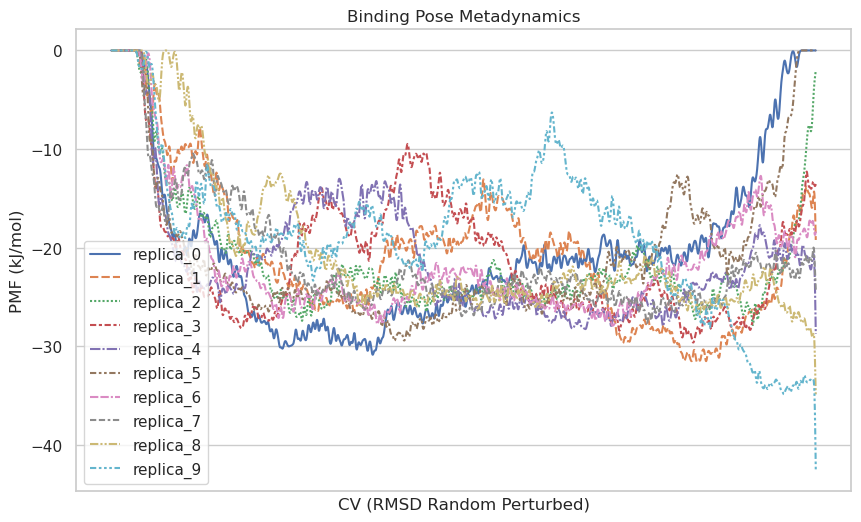

In [44]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=pmf_df)
plt.title("Binding Pose Metadynamics")
plt.xlabel("CV (RMSD Random Perturbed)")
plt.xticks([])
plt.ylabel("PMF (kJ/mol)")
plt.xticks([])
plt.legend()
plt.show()


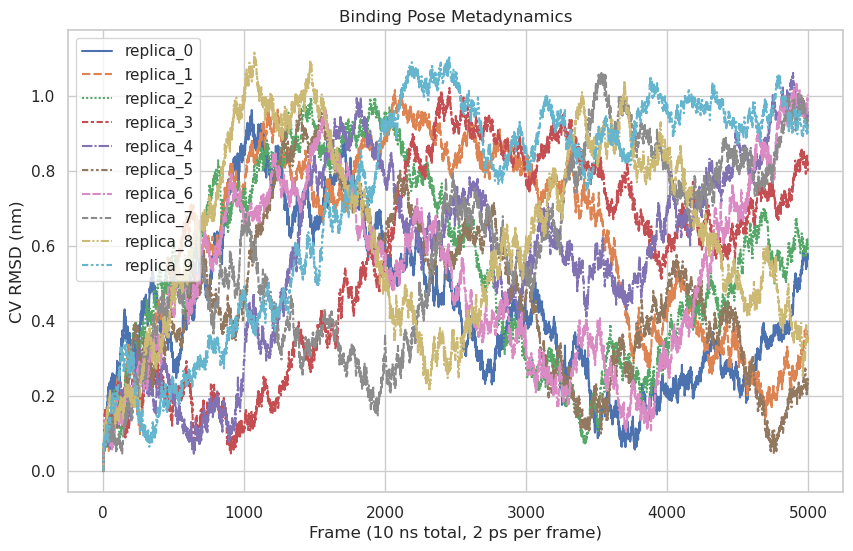

In [50]:
for i in range(10):
    cv_along_time = np.load(os.path.join(f'rep_{i}', 'COLVAR.npy')).squeeze()
    df = pd.DataFrame(cv_along_time, columns=[f'replica_{i}'])
    if i == 0:
        cv_df = df
    else:
        cv_df = pd.concat([cv_df, df], axis=1)

plt.figure(figsize=(10, 6))
sns.lineplot(data=cv_df)
plt.title("Binding Pose Metadynamics")
plt.xlabel("Frame (10 ns total, 2 ps per frame)")
plt.ylabel("CV RMSD (nm)")
plt.legend()
plt.show()